In [ ]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from keras.utils import np_utils

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
df.emotion.value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


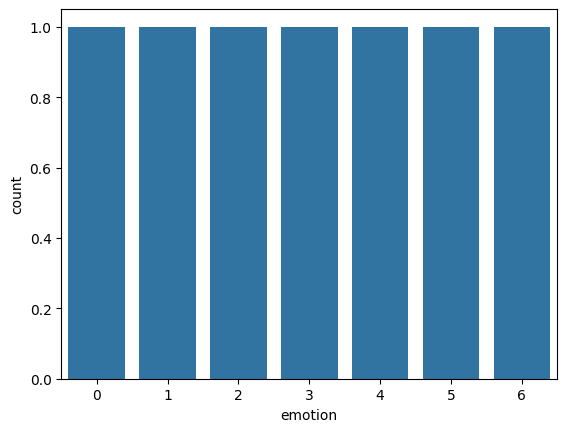

In [ ]:
sns.countplot(df.emotion.value_counts())
pyplot.show()

In [ ]:
#So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral nd we are also intersted in these three classes only.



In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))


48.0

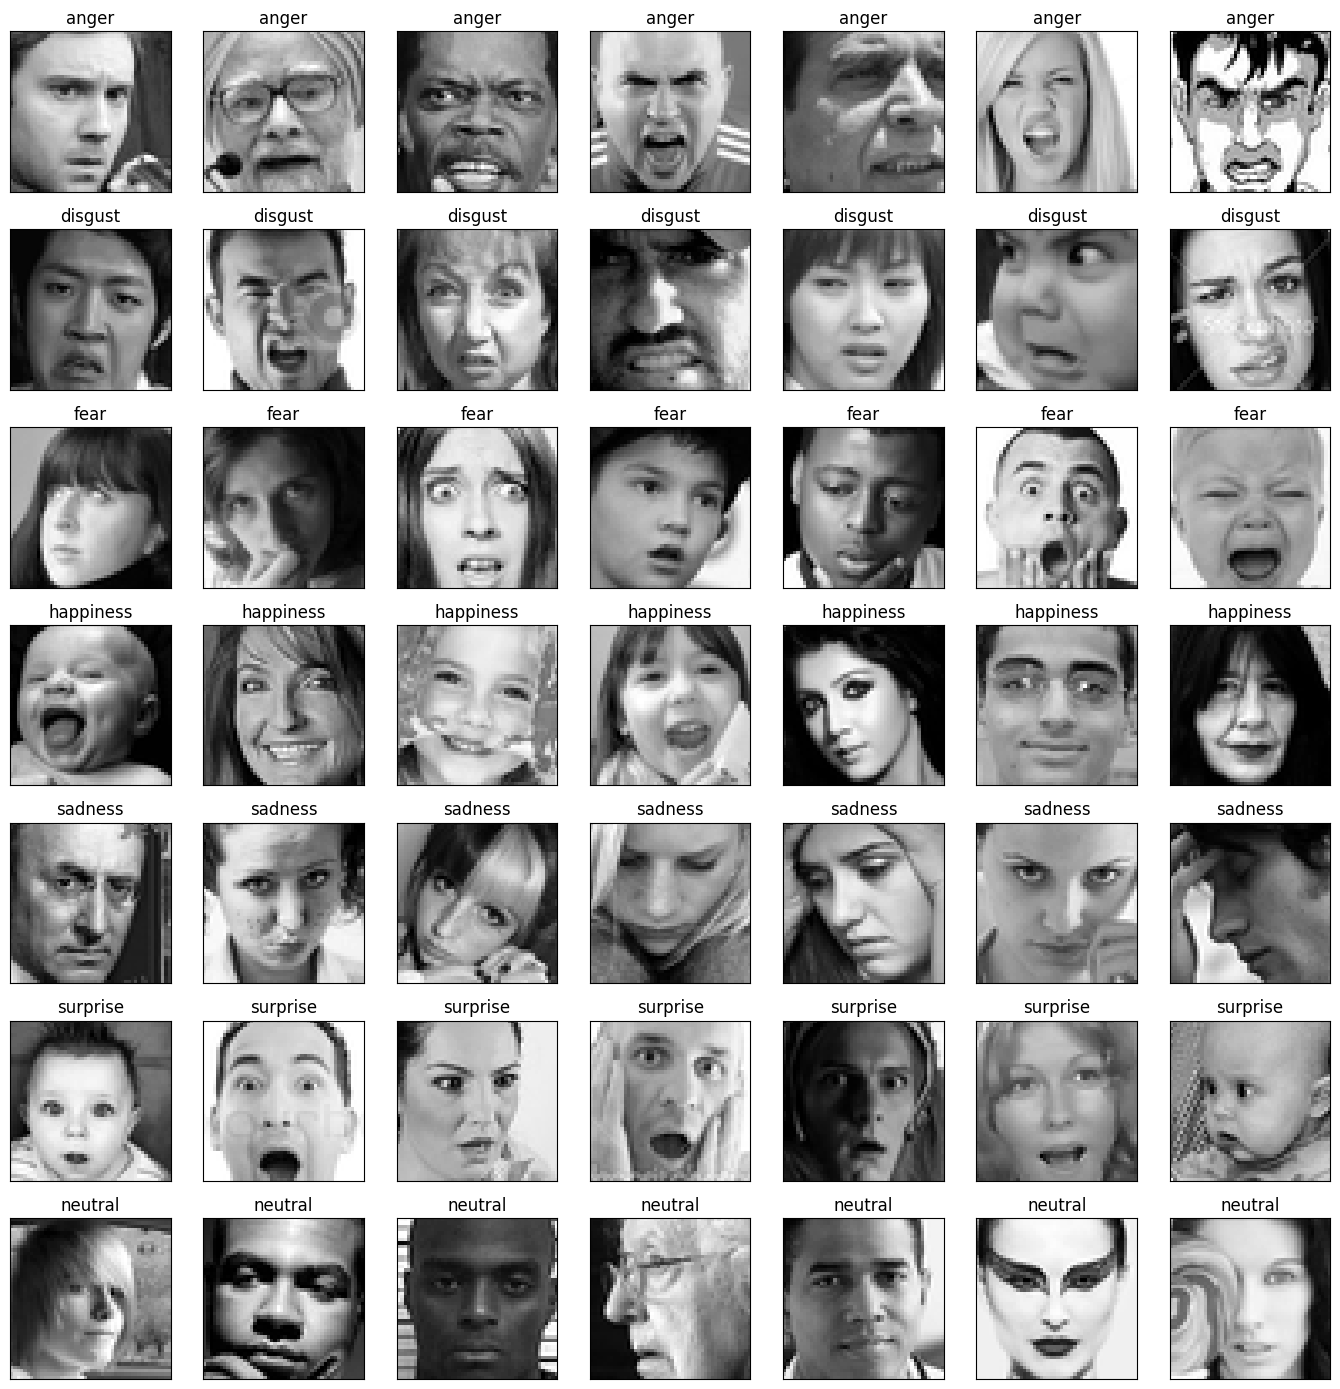

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
            px = df[df.emotion==label].pixels.iloc[k]
            px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

            k += 1
            ax = pyplot.subplot(7, 7, k)
            ax.imshow(px, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(emotion_label_to_text[label])
            pyplot.tight_layout()

In [ ]:
INTERESTED_LABELS = [3, 4, 6]
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape

(21264, 48, 48, 1)

In [ ]:
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{np.int64(3): np.int64(0), np.int64(4): np.int64(1), np.int64(6): np.int64(2)}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
def build_net(optim):
      net = Sequential(name='DCNN')
      net.add(
          Conv2D(
              filters=64,
              kernel_size=(5,5),
              input_shape=(img_width, img_height, img_depth),
              activation='elu',
              padding='same',
              kernel_initializer='he_normal',
              name='conv2d_1'
                )
          )
      net.add(BatchNormalization(name='batchnorm_1'))
      net.add(
          Conv2D(
              filters=64,
              kernel_size=(5,5),
              activation='elu',
              padding='same',
              kernel_initializer='he_normal',
              name='conv2d_2'
              )
          )
      net.add(BatchNormalization(name='batchnorm_2'))

      net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
      net.add(Dropout(0.4, name='dropout_1'))

      net.add(
         Conv2D(
             filters=128,
             kernel_size=(3,3),
             activation='elu',
             padding='same',
             kernel_initializer='he_normal',
             name='conv2d_3'
        )
    )
      net.add(BatchNormalization(name='batchnorm_3'))
      net.add(
         Conv2D(
             filters=128,
             kernel_size=(3,3),
             activation='elu',
             padding='same',
             kernel_initializer='he_normal',
             name='conv2d_4'
        )
    )
      net.add(BatchNormalization(name='batchnorm_4'))

      net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
      net.add(Dropout(0.4, name='dropout_2'))
      net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
      net.add(BatchNormalization(name='batchnorm_5'))
      net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
      net.add(BatchNormalization(name='batchnorm_6'))

      net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
      net.add(Dropout(0.5, name='dropout_3'))

      net.add(Flatten(name='flatten'))
      net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
      net.add(BatchNormalization(name='batchnorm_7'))

      net.add(Dropout(0.6, name='dropout_4'))

      net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

      net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

      net.summary()

      return net

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = build_net(optims[1])
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    epochs=epochs
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,075 (9.14 MB)

 Trainable params: 2,393,027 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


599/599 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.3941 - loss: 1.4686 - val_accuracy: 0.4791 - val_loss: 1.0446
Epoch 2/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4715 - loss: 1.0334 - val_accuracy: 0.5966 - val_loss: 0.8776
Epoch 3/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5342 - loss: 0.9576 - val_accuracy: 0.6342 - val_loss: 0.8144
Epoch 4/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6047 - loss: 0.8250 - val_accuracy: 0.6958 - val_loss: 0.6997
Epoch 5/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.6369 - loss: 0.7631 - val_accuracy: 0.7094 - val_loss: 0.6572
Epoch 6/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.6677 - loss: 0.7351 - val_accuracy: 0.7179 - val_loss: 0.6313
Epoch 7/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.6843 - loss: 0.7001 - val_accuracy: 0.7029 - val_loss: 0.6883
Epoch 8/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.7028 - loss: 0.6744 - val_

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


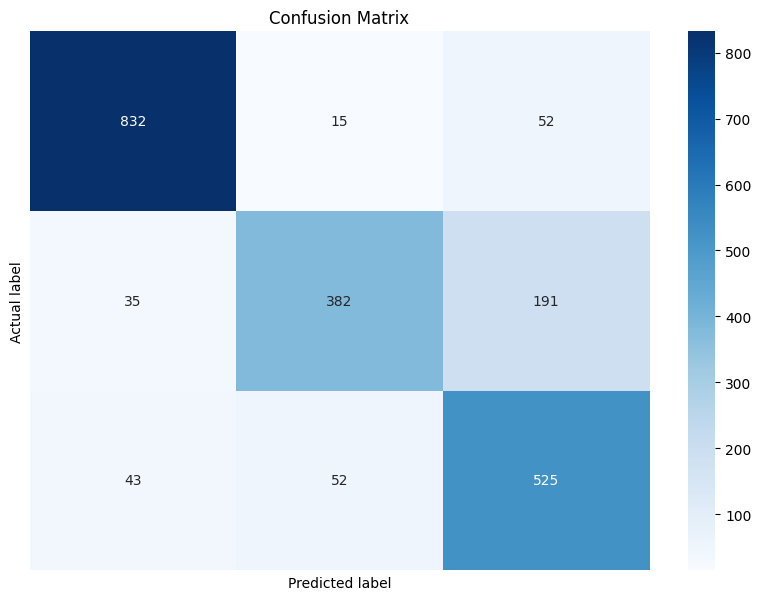

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

predictions = model.predict(X_valid)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_valid, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=False, yticklabels=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


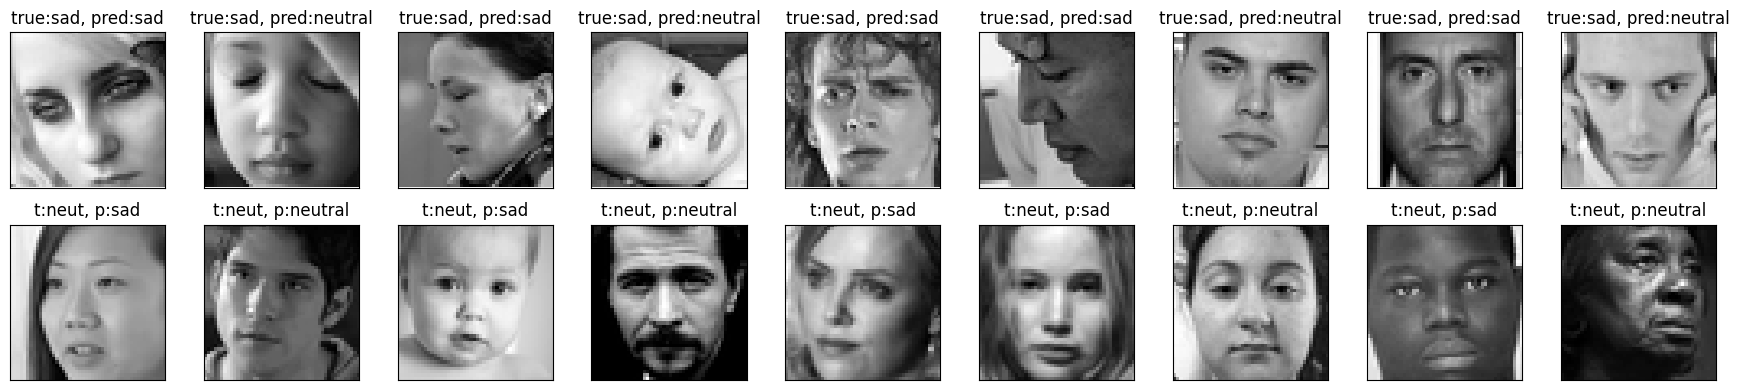

In [ ]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        prediction = model.predict(sample_img.reshape(1,48,48,1))
        predicted_class = np.argmax(prediction, axis=1)

        predicted_class_name = mapper[int(predicted_class[0])]
        ax.set_title(f"true:sad, pred:{predicted_class_name}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{predicted_class_name}")

        pyplot.tight_layout()

In [ ]:
tf.keras.models.save_model(model, 'face_model.keras')